[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/search/semantic-search/jeopardy/jeopardy.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/search/semantic-search/jeopardy/jeopardy.ipynb)

# Do-it-yourself Jeopardy Board Curation with Pinecone

<table><tr>
<td> <img src="https://d33wubrfki0l68.cloudfront.net/682006698903a55560c796b901fdfe4446c6d27a/a00ee/images/pinecone-logo.svg" alt="Pinecone" style="width: 1000px;"/> </td>
<td> <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/51/Jeopardy%21_game_board_US.svg/2880px-Jeopardy%21_game_board_US.svg.png" alt="Jeopardy Image" style="width: 1000px;"/> </td>
</tr></table>

## Background

### What is Semantic Search and how will we use it to play Jeopardy?

We are going to use Pinecone's semantic search capabilities with an off-the-shelf and a pretrained model to curate custom categories of previously-aired Jeopardy questions. We will also show how Pinecone makes it easy to ensure that question difficulty is on par with how the question was originally priced.

_Semantic search_ is exactly the kind of search where the _meaning_ of the search query is the thing that's used, rather than it being done by keyword lookups. Neural networks trained on large sets of text data have been shown to be very effective at encoding the _meaning_ of a particular phrase, sentence, paragraph or long document into a data structure known as a [vector embedding](https://www.pinecone.io/learn/vector-embeddings/).

### Learning Goals and Estimated Reading Time
_By the end of this 10 minute demo, you will have:_
 1. Learned about Pinecone's value for solving realtime semantic search requirements!
 2. Stored and retrieved vectors from Pinecone your very-own Pinecone Vector Database.
 3. Encoded Jeopardy Questions as 384-dimensional vectors using a pretrained, encoder-only, model (i.e. no model training necessary).
 4. Queried Pinecone's Vector Database on Jeopardy Questions that are semantically similar to the query.
 5. Bonus for the Interested Reader: Near-Instant Custom Jeopardy Board Creation With Increasing Question Difficulty!
 
 If you want to execute the code yourself either in Google Colab or your computer, it may take up to an hour depending on processing speed.

## Setup: Prerequisites and Data Preparation

### Python 3.7+

This code has been tested with Python 3.7. It is recommended to run this code in a virtual environment or Google Colab.

### Acquiring your Pinecone API Key

A Pinecone API key is required. You can obtain one for free on our [our website](https://app.pinecone.io/). Either add `PINECONE_EXAMPLE_API_KEY` to your list of environmental variables, or manually enter it after running the below cell (a prompt will pop up requesting the API key, storing the result within this kernel (session)).

### Installing and Importing Prerequisite Libraries:
Common Python libraries, including [pinecone-client](https://pypi.org/project/pinecone-client/) and [sentence_transformers](https://pypi.org/project/sentence-transformers/) are required for this notebook. They will be installed in the next cell.

#### Installing via `pip`

In [1]:
!pip install pinecone-client sentence-transformers datasets pandas tqdm httpimport -qU

### Helper Module

In [2]:
# There is a helper module required for this notebook to run.
# When not present with this notebook, it will be streamed in from Pinecone's Example Repository.
# You can find the module at https://github.com/pinecone-io/examples/tree/master/jeopardy

import os
import httpimport

if os.path.isfile('helper.py'):
    import helper as h
else:
    print('importing `helper.py` from https://github.com/pinecone-io')
    with httpimport.github_repo(
        username='pinecone-io', 
        repo='examples',
        module=['jeopardy'],
        branch='master'):
        from jeopardy import helper as h

Extracting API Key from environmental variable `PINECONE_EXAMPLE_API_KEY`...

Pinecone API Key available at `h.pinecone_api_key`

#### Importing and Defining Constants

In [3]:
import collections

import tqdm
import pinecone
import pandas as pd
from sentence_transformers import SentenceTransformer
from datasets import load_dataset

INDEX_NAME, INDEX_DIMENSION = 'jeopardy', 384
MODEL_NAME = 'sentence-transformers/msmarco-MiniLM-L6-cos-v5'

### Downloading and Processing Data

#### Downloading data
The [Jeopardy Dataset](https://huggingface.co/datasets/jeopardy) will be downloaded using the `datasets` library from HuggingFace.

In [4]:
rows = 20_000  # increase/decrease this to use more/less data, or
# remove the `split` keyword argument to get the entire dataset (has a little over 200,000 rows)
# Using the entire dataset will take longer to get through this demo, and not recommended as a first pass

dataset = load_dataset("jeopardy", split=f"train[130000:{130_000+rows}]")

Using custom data configuration default
Reusing dataset jeopardy (/Users/steven/.cache/huggingface/datasets/jeopardy/default/0.1.0/774efb3257b2f482b1974faa754e6ce11853ad625a9b364e29f106052afe0204)


#### The preprocessing step is self-explanatory and defined in the helper module.

In [5]:
df = dataset.to_pandas()
df = h.get_processed_df(df)

#### Sample row from dataframe

In [6]:
pd.DataFrame(df.iloc[1234])

,1443
category,NAME THAT NOVEL
air_date,1997-09-04 00:00:00
question,"'""'What a pretty little Nell!' cried Quilp.""'"
amount,1000
answer,The Old Curiosity Shop
round,Double Jeopardy!
show_number,2989
year,1997
month,09
text_to_encode,"'""'What a pretty little Nell!' cried Quilp.""' The Old Curiosity Shop"


### Creating your Pinecone Index
The process for creating a Pinecone Index requires your Pinecone API key, the name of your index, and the number of dimensions of each vector. As we will see below, the model we are using maps each piece of text to a 384-dimensional vector.

In [7]:
pinecone.init(api_key=h.pinecone_api_key, environment='us-west1-gcp')

if INDEX_NAME not in pinecone.list_indexes():
    pinecone.create_index(name=INDEX_NAME, dimension=INDEX_DIMENSION)

index = pinecone.Index(index_name=INDEX_NAME)

## Generate embeddings and send them to your Pinecone Index
This will all be done in batches. We will compute embeddings in batch, followed by taking each batch and sending it to Pinecone, also in batches.

### Loading a Pretrained Encoder model.
We will generate embeddings by using [this Sentence Transformers model](https://huggingface.co/sentence-transformers/msmarco-MiniLM-L6-cos-v5). It is one of hundreds of encoder models available. Downloads happen automatically with SentenceTransformer, and may take up to a minute the first time. After this first import, the model is cached and available on a local machine.

In [8]:
h.printmd(f'Loading model from _Sentence Transformers_: `{MODEL_NAME}` from Sentence Transformers...')
model = SentenceTransformer(MODEL_NAME)
h.printmd('Model loaded.')

Loading model from _Sentence Transformers_: `sentence-transformers/msmarco-MiniLM-L6-cos-v5` from Sentence Transformers...

Model loaded.

### MSMARCO model v5 and Embeddings

In this example, we created an index with 384 dimensions because that is what the output is of this MSMARCO model. In fact, particular MSMARCO model used in this example generates [unit vectors](https://en.wikipedia.org/wiki/Unit_vector), which make [vector comparisons](https://towardsdatascience.com/importance-of-distance-metrics-in-machine-learning-modelling-e51395ffe60d) agnostic to one's choice of similarity scores. In other words, when defining the index, it does not matter whether we use `euclidean`, `cosine` or `dotproduct` as a metric, so we left it blank, using the `cosine` default. 

#### On Embeddings

The output of this model's encodings are 384-dimensional, which was known in advance of creating above index.

So, when a piece of text such as "A quick fox jumped around" gets encoded into a vector embedding, the result is a sequence of floats.

#### On Comparing Embeddings aka _how_ Semantic Search works

Two 15-dimensional text embeddings might look like something like: 
 - _\[-0.02, 0.06, 0.0, 0.01, 0.08, -0.03, 0.01, 0.02, 0.01, 0.02, -0.07, -0.11, -0.01, 0.08, -0.04\]_
 - _\[-0.04, -0.09, 0.04, -0.1, -0.05, -0.01, -0.06, -0.04, -0.02, -0.04, -0.04, 0.07, 0.03, 0.02, 0.03\]_
 
In order to determine how _similar_ we may use something like [cosine distance](https://en.wikipedia.org/wiki/Cosine_similarity). This calculation is trivial when comparing two vectors, but nontrivial when needing to compare one vector against millions or billions of vectors.

### What is Pinecone for?
Often, there is a technical requirement to run a comparison of one vector to millions of others and return the most similar results in real time, with a latency of tens of milliseconds and at a high throughput. Pinecone solves this  problem with its managed vector database service, and we will demonstrate this below. 

### Prepare vector embeddings for upload

This may take a while depending on your machine. If on a recent MacBookPro or Google Colab, this may take up to one hour, sometimes longer.

#### Prepare metadata

The function below creates metadata from a single row of the dataframe. This is going to be important further down this notebook for additional filter requirements we will may want to employ in our queries.

In [9]:
def get_vector_metadata_from_dataframe_row(df_row):
    """Return pinecone vector."""
    vector_metadata = {
        'year': df_row['year'],
        'month': df_row['month'],
        'round': df_row['round'],
        'amount': df_row['amount']
    }
    return vector_metadata

#### Prepare all vector data for upload

The function below will take a portion of the dataframe and create the full vector data as Pinecone expects it for [upsert](https://www.pinecone.io/docs/insert-data/).

In [10]:
def get_vectors_to_upload_to_pinecone(df_chunk, model):
    """Return list of tuples like (vector_id, vector_values, vector_metadata)."""
    # create embeddings
    pool = model.start_multi_process_pool()
    vector_values = model.encode_multi_process(df_chunk['text_to_encode'], pool).tolist()
    model.stop_multi_process_pool(pool)
    # create vector ids and metadata
    vector_ids = df_chunk.index.tolist()
    vector_metadata = df_chunk.apply(get_vector_metadata_from_dataframe_row,axis=1).tolist()
    return list(zip(vector_ids, vector_values, vector_metadata))

### Upload data to Pinecone in asynchronous batches

The function below iterates through the dataframe in chunks, and for each of those chunks, will upload asynchronously in sub-chunks to your Pinecone Index.

In [11]:
def upload_dataframe_to_pinecone_in_chunks(
    dataframe, 
    pinecone_index, 
    model, 
    chunk_size=20000, 
    upsert_size=100):
    """Encode dataframe column `text_to_encode` to dense vector and upsert to Pinecone."""
    tqdm_kwargs = h.get_tqdm_kwargs(dataframe, chunk_size)
    async_results = collections.defaultdict(list)
    for df_chunk in tqdm.notebook.tqdm(h.chunks(dataframe, chunk_size), **tqdm_kwargs):
        vectors = get_vectors_to_upload_to_pinecone(df_chunk, model)
        # upload to Pinecone in batches of `upsert_size`
        for vectors_chunk in h.chunks(vectors, upsert_size):
            start_index_chunk = df_chunk.index[0]
            async_result = pinecone_index.upsert(vectors_chunk, async_req=True)
            async_results[start_index_chunk].append(async_result)
        # wait for results
        _ = [async_result.get() for async_result in async_results[start_index_chunk]]
        is_all_successful = all(map(lambda x: x.successful(), async_results[start_index_chunk]))
        # report chunk upload status
        print(
        f'All upserts in chunk successful with index starting with {start_index_chunk:>7}: '
        f'{is_all_successful}. Vectors uploaded: {len(vectors):>3}.'
        )
    return async_results

#### Asynchronous Upload
Computing the embeddings may take up to a couple of minutes per 20k vector chunk depending on hardware capabilities. Once computed it will be nearly instantaneous to send the embeddings to Pinecone. The Pinecone API responds right away with its [async](https://www.pinecone.io/docs/insert-data/#sending-upserts-in-parallel) requests. 

Note: You may see the following output a few times when executing, it is not an error: 
```
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
```

In [12]:
async_results = upload_dataframe_to_pinecone_in_chunks(df, index, model)

  0%|          | 0/1 [00:00<?, ?chunk of vectors/s]

All upserts in chunk successful with index starting with       0: True. Vectors uploaded: 16917.


### Visualize the status of your upserts in the Pinecone Console

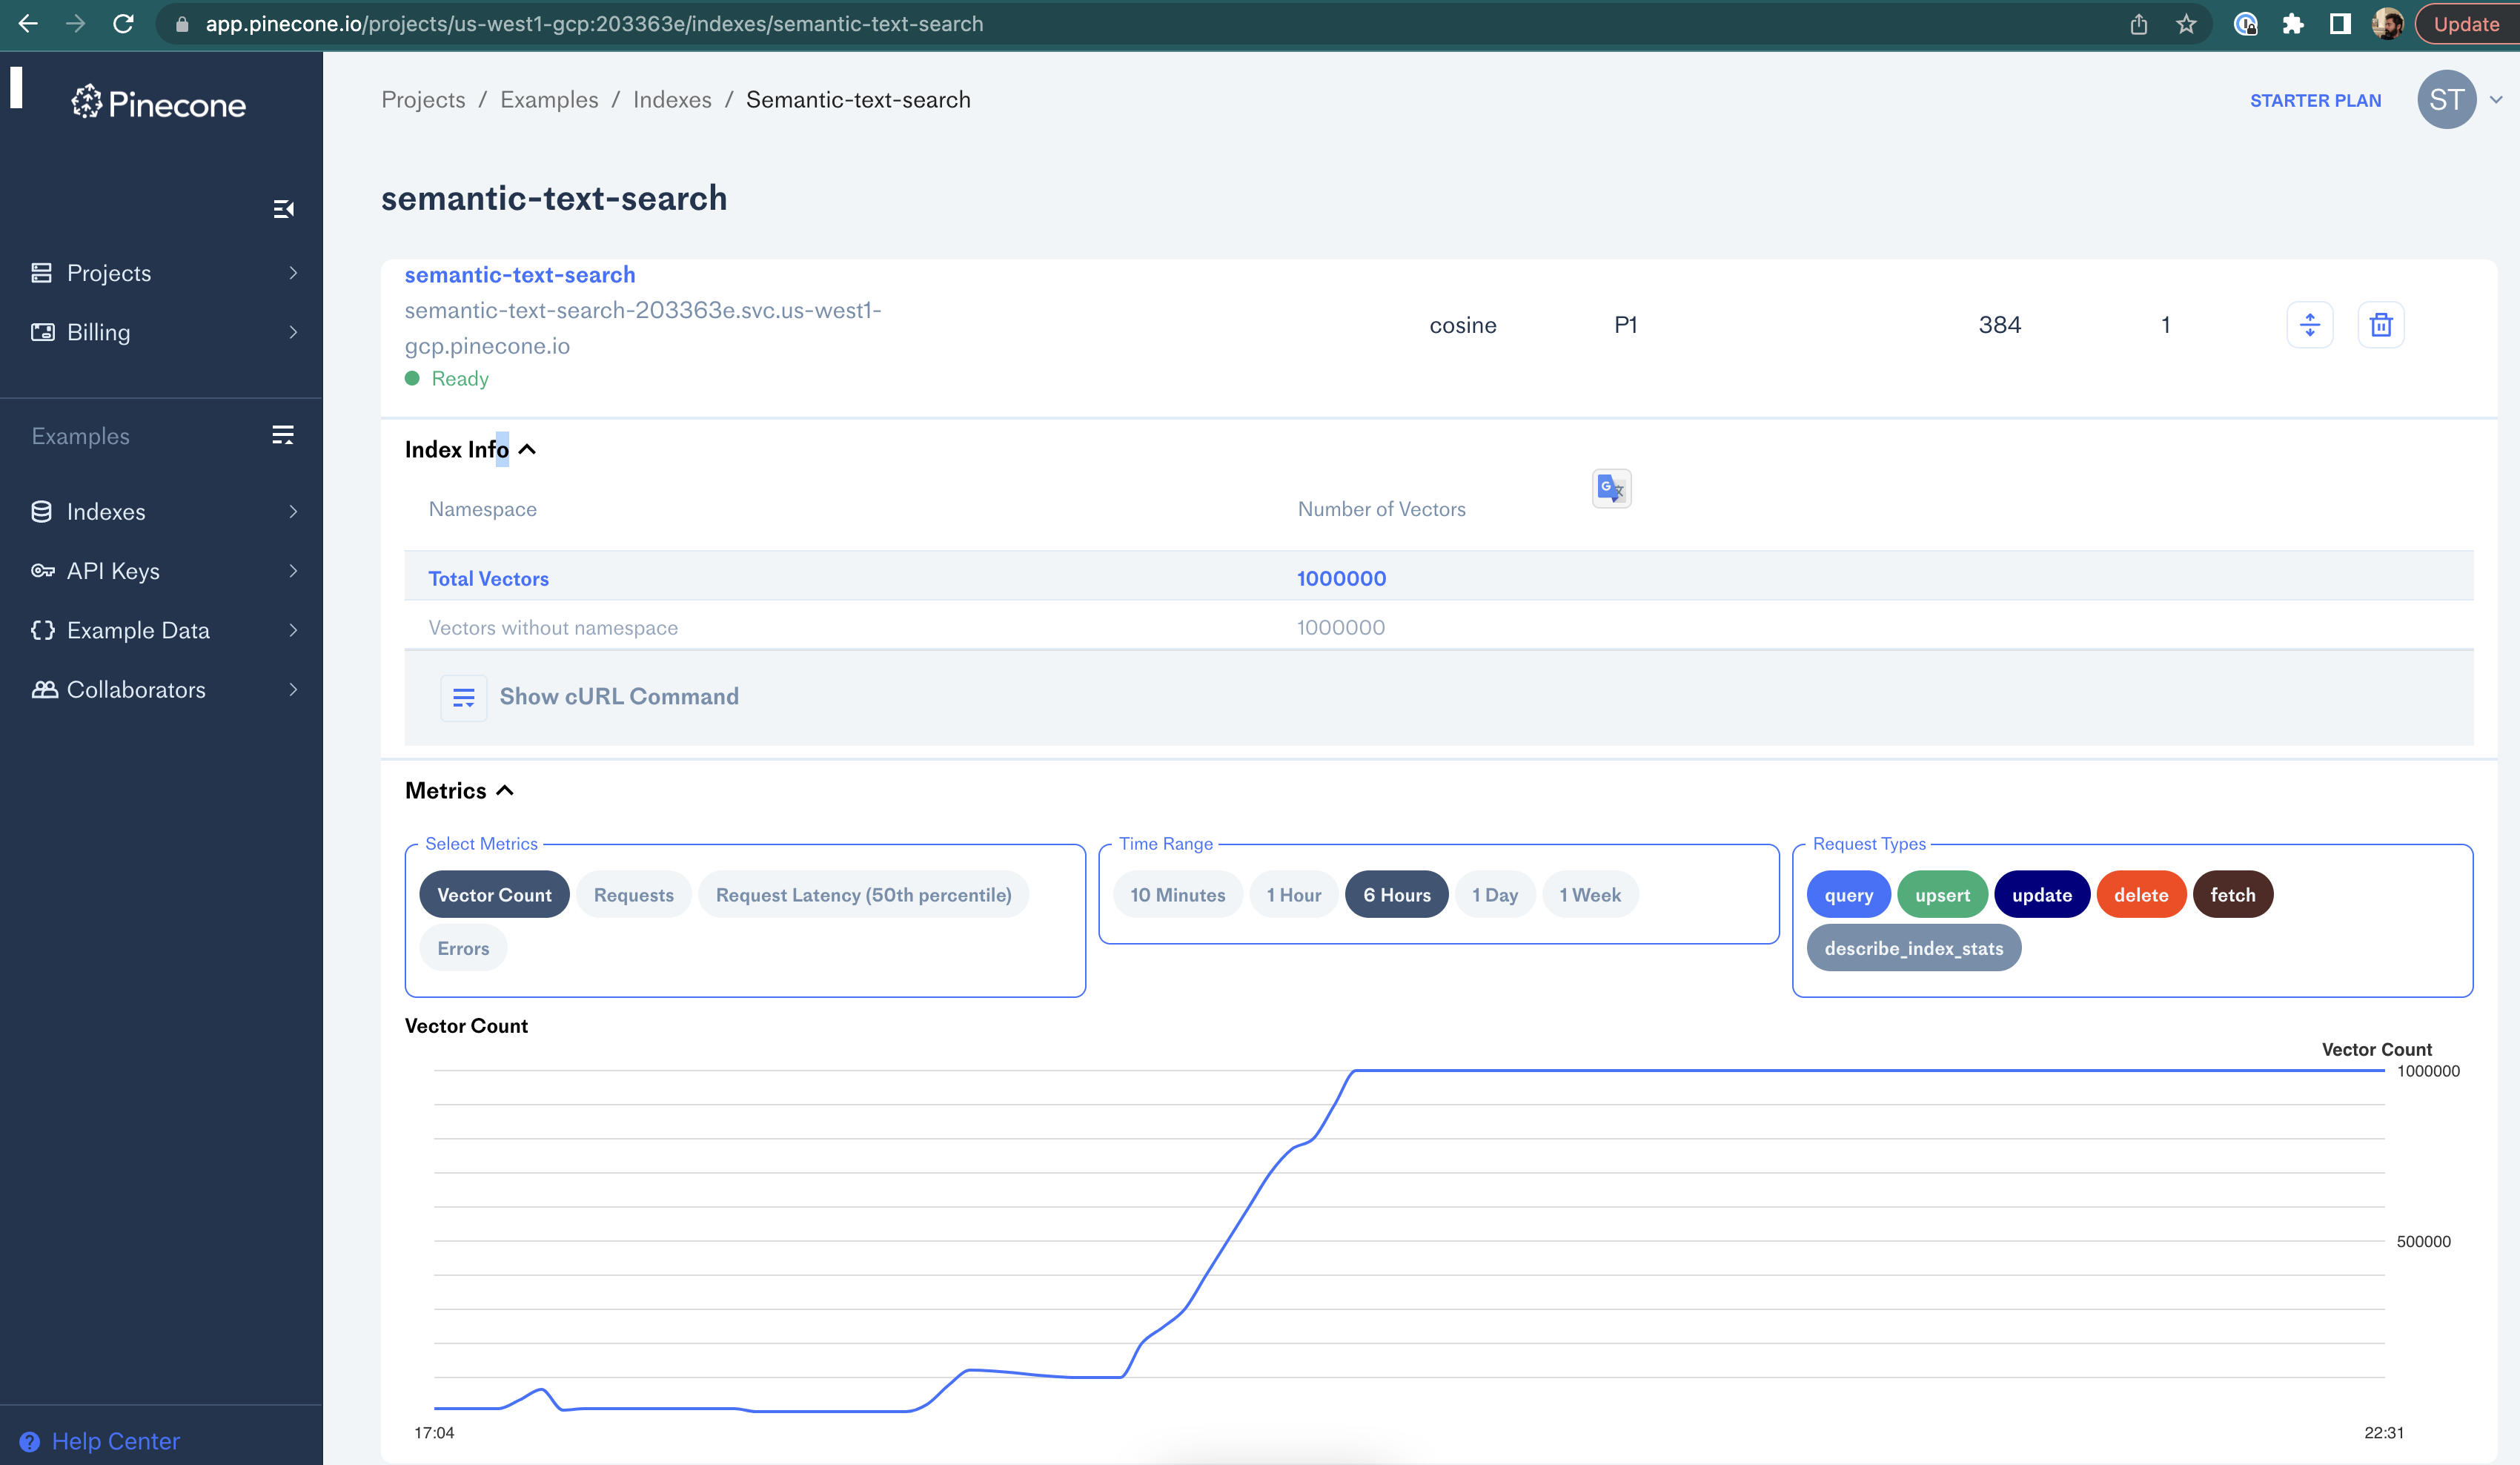

## Querying Pinecone

Now that all the embeddings of the texts are on Pinecone's database, it's time to demonstrate Pinecone's lightning fast semantic search query capabilities.

### Pinecone Example Usage

#### _**Show me Jeopardy questions that are semantically similar to "ancient attitudes"\!**_

In the below example we query Pinecone's API with an embedding of a query term to return the vector embeddings that have the highest similarity score. In other words, Pinecone does all the work to effeciently determine which of the uploaded vector embeddings have the highest similarity when paired with the query term's embedding.

#### Example: Pinecone API Request

A sample request for questions that that a similar semantic meaning to _ancient attitudes_.

In [13]:
query = 'ancient attitudes'
vector_embedding = model.encode(query).tolist()
response = index.query(vector_embedding, top_k=3, include_metadata=True)

#### Pinecone API Response
A typical Pinecone response to the above query.

In [22]:
response

{'matches': [{'id': '1253',
              'metadata': {'amount': 1200.0,
                           'month': '01',
                           'round': 'Double Jeopardy!',
                           'year': '2006'},
              'score': 0.510472775,
              'values': []},
             {'id': '18032',
              'metadata': {'amount': 400.0,
                           'month': '11',
                           'round': 'Double Jeopardy!',
                           'year': '1991'},
              'score': 0.39200142,
              'values': []},
             {'id': '9436',
              'metadata': {'amount': 1000.0,
                           'month': '06',
                           'round': 'Jeopardy!',
                           'year': '2011'},
              'score': 0.389682949,
              'values': []}],
 'namespace': ''}

#### Enriched Response
To show which questions we retreived, the above response needs to be enriched using the original dataset.

In [15]:
h.get_query_results_from_api_response(df, response, query)

,question,answer,amount,query
vector_id,,,,
1253,'Modern cultural movement emphasizing alternative approaches to spirituality',New Age,1200,ancient attitudes
18032,'These historical epics which the Vikings learned by heart were passed on from generation to generation',Sagas/eddas,400,ancient attitudes
9436,"'This ""elder"" Roman writer died in 79 A.D. while rescuing people from mount Vesuvius' eruption'",Pliny (the Elder),1000,ancient attitudes


### Pinecone Example Usage With [Metadata](https://www.pinecone.io/docs/metadata-filtering/)

Some of the above do turn out to be related to _ancient attidues_, which is pretty spectacular! _Note that this is **not a keyword search** but rather a **search for semantically similar results**.

But we can do better! In Jeopardy, you choose a question **and** a price point, where, in general, higher prices indicate harder questions. So it is natural to want to choose semantically similar questions from a specific price point.

#### _Can I see 5 questions related to "ancient attitudes" for \$1000?_

Yes. Pinecone's [metadata feature](https://www.pinecone.io/docs/metadata-filtering/) makes this request trivial. We've already uploaded the metadata so filtering is just a Pinecone API request away. The only difference we make to the api request is to add the `filter_criteria` keyword argument like so: 

```python
index.query(vector_embedding, top_k=5, include_metadata=True, filter_criteria={'amount': {'$eq': 1000}})
```

In [16]:
h.get_query_results_from_query(query, index, df, model, top_k=5, filter_criteria={'amount': {'$eq': 1000}})

,question,answer,amount,query
vector_id,,,,
9436,"'This ""elder"" Roman writer died in 79 A.D. while rescuing people from mount Vesuvius' eruption'",Pliny (the Elder),1000,ancient attitudes
11124,'The most famous one of these shrines in the ancient world was located on the slopes of Mount Parnassus',Oracle,1000,ancient attitudes
3737,"'Books 12-19 of this ""elder"" ancient Roman's ""Natural History"" are devoted to botany'",Pliny the Elder,1000,ancient attitudes
19547,"'In the old Hindu caste system the twice-born castes were the Vaisyas, the Kshatriyas & this, which included priests'",Brahmins,1000,ancient attitudes
520,'We took the word nirvana from this classical language',Sanskrit,1000,ancient attitudes


Pretty good, right? Every question above is from the dataset, each one of them previously aired on Jeopardy for \$1000, and, while subjective, most of them have to do with _antient attidues_.

### An Additional Note on Metadata

This is a basic demonstration of metadata. Extensive predicate logic can be applied to metadata filtering, just like the [WHERE clause](https://www.pinecone.io/learn/vector-search-filtering/) in SQL!

## Conclusion

In this notebook, we demonstrated how trivial Pinecone makes instant retrieval of similar vector embeddings to create custom Jeopardy questions of a pre-assigned difficulty. We did not need to train any models or develop any algorithms to allow for this type of instant computation. This example is illustrative of how to use a pre-trained transformer-encoder model with Pinecone to achieve realtime similarity retrieval!

### Like what you see? Explore our [community](https://www.pinecone.io/community/)
Learn more about semantic search and the rich, performant, and production-level feature set of Pinecone's Vector Database by visiting https://pinecone.io, connect with us [here](https://www.pinecone.io/contact/) and [follow us](https://www.linkedin.com/company/pinecone-io) on LinkedIn.

## Bonus Material: Jeopardy Building Custom Jeopardy Boards

For the interested reader, we've created a few functions in the helper module that will automatically generate Jeopardy Boards. 

### Pinecone Query for All Question Difficulties
Now, we scale up the previous example and wrangle the output into the form of two Jeopardy Boards (First and second round).

### Jeopardy! Round 1 Board

In [17]:
queries = ["over the moon", "ancient atitudes", "invention of computer"]
jeopardy_questions = h.get_jeopardy_questions(queries, index, df, model)
jeopardy_board, double_jeopardy_board = h.get_jeopardy_boards(jeopardy_questions, queries)
jeopardy_board

,over the moon,ancient atitudes,invention of computer
amount,,,
200,'It's the colossal booster rocket that lifted the Apollo missions to the moon','In 1909 Dutch botanist Wilhelm Johannsen first proposed this name for the unit of heredity in living things','The World Almanac's list of inventions runs from Pascal's adding machine to this fastener by Judson'
400,'The casino named for this heavenly body will feature the scintillating lounge act of Neil Armstrong & Buzz Aldrin','These historical epics which the Vikings learned by heart were passed on from generation to generation','Around 132 A.D. Chinese scientist Chang Heng invented an early form of this earthquake detector'
600,'In June 1978 the first moon to be discovered around this planet was found by James W. Christy',"'As a boy in ancient China, this sage was known as Ch'iu, meaning ""hill"", because of his protuberant forehead'",'For 16 years this computer maker put an ad on the back page of PC Mag to promote & pioneer its direct PC sales'
800,'Earth's natural satellite between May & July',"'In ""The Village Blacksmith"", Longfellow wrote of this ""Sounding"" object that the Blacksmith's hammer strikes'","'Yankee profiled ""New England's greatest invention""--this one created in a restaurant on a Mass. toll road'"
1000,"'""Fly Me to the Moon"" is Volume V in the ""Great American Songbook"" series by this British rocker'","'According to Proverbs, ""He that troubleth his own house shall"" do this'","'In 1821, he became only person to invent, unaided, an entire alphabet & numbering system'"


### Double Jeopardy! Round 2 Board

In [18]:
double_jeopardy_board

,over the moon,ancient atitudes,invention of computer
amount,,,
1200,'High-aiming standard heard here',"'2 ways of gaining knowledge described by Kant were ""a posteriori"" & this Latin opposite'",'Invention (proverbially)'
1400,'One of these long-lived animals that died in 1966 was reportedly given to the King of Tonga by Captain Cook','In the 1770s this archduchess of Austria pioneered a national system of elementary education','In the 1770s this archduchess of Austria pioneered a national system of elementary education'
1600,'Shine on if you see this closest full moon to the fall equinox','Rowena has Saxon the brain in this 1819 work by Sir Walter Scott','...who conjured up Shangri-La for a 1933 novel'
1800,'This technology used for wireless headsets is named after a Danish king who united parts of Scandinavia','Muslims believe that Abraham helped build this building in Mecca thousands of years ago','This technology used for wireless headsets is named after a Danish king who united parts of Scandinavia'
2000,'335 B.C.:<br />This Greek philosopher uses lunar eclipses to prove the Earth is ball shaped','The major evidence that these people visited North America has been found at L'Anse aux Meadows',"'Ed Roberts built the first true personal computer & named it this model 8800, after a star'"


### Looking Up Answers!
See if you can think of the answer to this question which you can view in the above jeopardy board: 
#### _Over the moon for 400 please, Alex!_.

In [19]:
h.show_answer_widget(jeopardy_questions, queries)

Dropdown(description='query:', options=('over the moon', 'ancient atitudes', 'invention of computer'), value='…

Dropdown(description='amount:', options=(200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000), value=200)

Button(description='Submit', style=ButtonStyle())

Output()